# Renaissance REMI+ Experiment: Training-Validation Split and Data Augmentation

This notebook contains all the code necessary to load the preprocessed dataset and create HuggingFace datasets to train a model (cf. RenaissanceREMI_Train.ipynb), which can then be used for inference (cf. RenaissanceREMI_Generate.ipynb)

### Choose output directory

Since the model will require a GPU comparable to an A100, it is recommended to place the output from this notebook on Google Drive.  Whatever machine will train the model needs to have access to the chosen directory.

Uncomment the next cell to mount Drive.
If no Drive is mounted, then the output data directory will be relative to CWD.

In [1]:
# RECOMMEND MOUNTING DRIVE IF THE GOAL IS TO TRAIN A MODEL
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# will output to Drive if possible, otherwise relative to the cwd
BASE_OUTPUT_DIR = '/content/drive/MyDrive/RenaissanceREMI' \
                    if os.path.exists('/content/drive/MyDrive') \
                    else os.path.join(os.getcwd(), 'RenaissanceREMI')

In [3]:
import sys

if not os.path.exists("CounterpointTransformer"):
  !git clone https://github.com/iLykTurtlz/CounterpointTransformer.git


!pip install -e CounterpointTransformer

repo_path = os.path.abspath("CounterpointTransformer")
if repo_path not in sys.path:
    sys.path.append(repo_path)

Cloning into 'CounterpointTransformer'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2337/2337), done.
remote: Total 2927 (delta 636), reused 2870 (delta 586), pack-reused 0 (from 0)
Receiving objects: 100% (2927/2927), 10.07 MiB | 10.68 MiB/s, done.
Resolving deltas: 100% (636/636), done.
Updating files: 100% (2983/2983), done.
Obtaining file:///content/CounterpointTransformer
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.1 MB/s eta 0:00:00
  Running setup.py develop for ren_counterpoint


### Mount Drive, Imports, Set Up Directories

In [4]:
import mido
from symusic import Score
from datasets import load_from_disk
from pathlib import Path, PosixPath
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from dataclasses import dataclass, field

import matplotlib.pyplot as plt

# imports from github/iLykTurtlz/CounterpointTransformer
from ren_counterpoint.tokenizer import RemiPlusTokenizer
from ren_counterpoint.dataset import build_polyphony_dataset
from ren_counterpoint.data_augmentation import process_directory_parallel

In [5]:
REPO_ROOT = os.path.join(os.getcwd(), 'CounterpointTransformer')
DATA_PATH = os.path.join(REPO_ROOT, "data")

# GitHub data subdirectories
JOSQUIN = os.path.join(DATA_PATH, "Josquin")
SIMSSA = os.path.join(DATA_PATH, "Simssa")

# subdirectories of the output directory
TOKENIZER_PATH = os.path.join(BASE_OUTPUT_DIR, 'RenaissanceREMI.json')
CHECKPOINT_DIR = os.path.join(BASE_OUTPUT_DIR, 'checkpoints')
TRAIN_DIR = os.path.join(BASE_OUTPUT_DIR, 'augmented_train_data')
VAL_DIR = os.path.join(BASE_OUTPUT_DIR, 'augmented_val_data')
DATASET_DIR = os.path.join(BASE_OUTPUT_DIR, 'dataset')
AUGMENTED_TRAIN_DATASET_PATH = os.path.join(DATASET_DIR, 'augmented_train_dataset')
AUGMENTED_VAL_DATASET_PATH = os.path.join(DATASET_DIR, 'augmented_val_dataset')

In [6]:
# constants
SEED=42

In [10]:
directories = [
  CHECKPOINT_DIR,
  TRAIN_DIR,
  VAL_DIR,
  DATASET_DIR,
]

for d in directories:
    Path(d).mkdir(parents=True, exist_ok=True)
    print(f"Verified directory: {d}")

Verified directory: /content/drive/MyDrive/RenaissanceREMI/checkpoints
Verified directory: /content/drive/MyDrive/RenaissanceREMI/augmented_train_data
Verified directory: /content/drive/MyDrive/RenaissanceREMI/augmented_val_data
Verified directory: /content/drive/MyDrive/RenaissanceREMI/dataset


### Gather Files

In [8]:
base_paths = [ JOSQUIN, SIMSSA ]

midi_paths = []
for base_path in base_paths:
  if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                # Construct the full path
                full_path = os.path.join(root, file)
                midi_paths.append(full_path)
  else:
      print(f"Directory not found: {base_path}")
      print("Please verify the folder name and location in your Drive.")
print(f"Found {len(midi_paths)} MIDI files.")

Found 2965 MIDI files.


In [11]:
# verify that the n tracks of each example are 0,1,...,n-1
for i,path in enumerate( tqdm( midi_paths ) ):
  m = mido.MidiFile(path)
  prog = 0
  for j,track in enumerate(m.tracks):
    if any(msg.type == 'note_on' for msg in track):
      for msg in track:
        if msg.type == 'program_change':
          assert msg.program == prog, f"Found an odd program number {msg.program} in path idx {i}, track {j}.  Should have been program {prog}"
          prog += 1
          break

  0%|          | 0/2965 [00:00<?, ?it/s]

In [12]:
# exclude token sequence length outliers (very long sequences)
excluded = \
[ os.path.join(SIMSSA, name) for name in \
  ('Magnificat_Primi_Toni-todos.mid',
   'Magnificat_Sexti_Toni-todos.mid',
   'Pro_Victoria-3-Credo.mid',) ] + \
[ os.path.join(JOSQUIN, name) for name in \
  ('Bru1008c-Missa_Et_ecce_terre_motus-Credo.mid',
   'Bru1008d-Missa_Et_ecce_terre_motus-Sanctus.mid',
   'Bru1008b-Missa_Et_ecce_terre_motus-Gloria.mid',
   'Bru1008a-Missa_Et_ecce_terre_motus-Kyrie.mid',) ]

before_len = len(midi_paths)
midi_paths = [p for p in midi_paths if p not in excluded]
after_len = len(midi_paths)
assert before_len - after_len == len(excluded), f"Should have removed {len(excluded)} files, but before had {before_len} files and after {after_len}.  Has this cell already been run?"

### WARNING: Symusic has a bug when detecting programs

Demonstration: compare the number of tracks containing notes detected by mido vs. symusic

* The mido.MidiFile should have tracks with programs increasing from 0, possibly with no program for its metadata track.

* The symusic.Score should have the same programs as the mido.MidiFile, even if the metadata track is not there.

If a symusic.Score gives multiple tracks the same program, from the point of view of the tokenizer, they are the same track.

This problem becomes more pronounced after data augmentation.

In [14]:
nb_errors = 0
err_indices = []
for i, path in enumerate( tqdm(midi_paths) ):
  s = Score(path)
  m = mido.MidiFile(path)
  symusic_tracks = sum( len(track.notes) > 0 for track in s.tracks )
  mido_tracks = sum( any(msg.type == 'note_on' for msg in track) for track in m.tracks )
  if symusic_tracks != mido_tracks:
    print(f"idx {i}, path {path}:")
    print(f"\tsymusic_tracks={symusic_tracks}, mido_tracks={mido_tracks}")
    err_indices.append(i)
    nb_errors += 1
print(f"TOTAL ERRORS: {nb_errors}")



  0%|          | 0/2958 [00:00<?, ?it/s]

idx 2535, path /content/CounterpointTransformer/data/Simssa/Rue2012-Magnificat_Sexti_toni.mid:
	symusic_tracks=4, mido_tracks=7
TOTAL ERRORS: 1


In [15]:
s = Score(midi_paths[err_indices[0]])
m = mido.MidiFile(midi_paths[err_indices[0]])

symusic_programs = [track.program for track in s.tracks]
mido_programs = {i:[msg.program for msg in track if msg.type=='program_change'] for i,track in enumerate(m.tracks)}

print(f"symusic_programs={symusic_programs}")
print(f"mido_programs={mido_programs}")

symusic_programs=[0, 2, 3, 0]
mido_programs={0: [], 1: [0], 2: [1], 3: [2], 4: [3], 5: [4], 6: [5], 7: [6]}


### Tokenizer (create if it doesn't exist)

In [16]:
if Path(TOKENIZER_PATH).exists():
  tokenizer = RemiPlusTokenizer(load_path=TOKENIZER_PATH)
else:
  tokenizer = RemiPlusTokenizer()
  tokenizer.save(TOKENIZER_PATH)

/usr/local/lib/python3.12/dist-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


### Debug Files - drop all files with issues

#### Remove duplicate files

In [17]:
# There are some duplicate pieces between the Josquin and the Simssa directories
# stems = {}
# for i,path in enumerate(midi_paths):
#   stem = Path(path).stem
#   if stem in stems:
#     print(path + "\n\t" + midi_paths[stems[stem]])
#   else:
#     stems[stem] = i

# Solution: take Josquin example over Simssa example whenever the stems are identical
jdir = PosixPath(JOSQUIN)
sdir = PosixPath(SIMSSA)
josquin_paths = [p for p in midi_paths if Path(p).parent == jdir]
simssa_paths = [p for p in midi_paths if Path(p).parent == sdir]
assert len(josquin_paths) + len(simssa_paths) == len(midi_paths)
j_stems = {Path(p).stem for p in josquin_paths}
s_stems = {Path(p).stem for p in simssa_paths}
assert(len(j_stems) == len(josquin_paths))
assert(len(s_stems) == len(simssa_paths))
midi_paths = josquin_paths + [p for p in simssa_paths if Path(p).stem not in j_stems]
print(f"After removing duplicates, we have {len(midi_paths)} files remaining")

After removing duplicates, we have 2456 files remaining


#### Drop files with tokenization issues

Even with the tokenizer using mido to correct symusic's errors, there are some files that still have issues.  As long as their number is small, it's reasonable to just drop them.

Once again, the mido.MidiFile is the ground truth.

### Super fastidious check to ensure files can be tokenized accurately



In [18]:
@dataclass
class Note:
    """A note with all attributes needed for comparison."""
    pitch: int
    start_tick: int
    duration: int
    program: int

    def __repr__(self):
        return f"Note(p={self.pitch}, t={self.start_tick}, dur={self.duration}, prog={self.program})"


@dataclass
class VerificationResult:
  """Detailed results of tokenization verification."""
  path: str
  success: bool = True

  # Stats
  original_note_count: int = 0
  token_note_count: int = 0
  original_programs: set = field(default_factory=set)
  token_programs: set = field(default_factory=set)

  # Per-program counts
  original_notes_by_program: dict = field(default_factory=dict)
  token_notes_by_program: dict = field(default_factory=dict)

  # Errors
  missing_notes: list = field(default_factory=list)
  extra_notes: list = field(default_factory=list)
  wrong_program_notes: list = field(default_factory=list)  # (original_note, token_program)
  pitch_mismatches: list = field(default_factory=list)  # Details of pitch-level mismatches

  error_message: str = ""

  def __str__(self):
    if self.success:
        return f"✓ {self.path}: OK ({self.original_note_count} notes, programs {self.original_programs})"

    lines = [f"{self.path}: FAILED"]

    if self.original_programs != self.token_programs:
        lines.append(f"  Programs: {self.original_programs} -> {self.token_programs}")

    if self.original_note_count != self.token_note_count:
        lines.append(f"  Note count: {self.original_note_count} -> {self.token_note_count}")

    # Per-program breakdown
    all_progs = self.original_programs | self.token_programs
    for prog in sorted(all_progs):
        orig = self.original_notes_by_program.get(prog, 0)
        tok = self.token_notes_by_program.get(prog, 0)
        if orig != tok:
            lines.append(f"    Program {prog}: {orig} -> {tok}")

    if self.pitch_mismatches:
        lines.append(f"  Pitch-level mismatches: {len(self.pitch_mismatches)}")
        for mismatch in self.pitch_mismatches[:5]:
            lines.append(f"    Pitch {mismatch['pitch']}: mido={mismatch['mido_progs']}, tokens={mismatch['token_progs']}")
        if len(self.pitch_mismatches) > 5:
            lines.append(f"    ... and {len(self.pitch_mismatches) - 5} more")

    if self.wrong_program_notes:
        lines.append(f"  Wrong program: {len(self.wrong_program_notes)} notes")
        for orig_note, tok_prog in self.wrong_program_notes[:5]:
            lines.append(f"    {orig_note} -> assigned to program {tok_prog}")
        if len(self.wrong_program_notes) > 5:
            lines.append(f"    ... and {len(self.wrong_program_notes) - 5} more")

    if self.missing_notes:
        lines.append(f"  Missing notes: {len(self.missing_notes)}")
        for note in self.missing_notes[:3]:
            lines.append(f"    {note}")
        if len(self.missing_notes) > 3:
            lines.append(f"    ... and {len(self.missing_notes) - 3} more")

    if self.extra_notes:
        lines.append(f"  Extra notes: {len(self.extra_notes)}")

    if self.error_message:
        lines.append(f"  Error: {self.error_message}")

    return "\n".join(lines)


def extract_notes_from_mido(midi_path: str | Path) -> list[Note]:
  """
  Extract all notes from MIDI using mido (ground truth).
  Returns list of Note objects with correct program assignments.
  """
  mid = mido.MidiFile(midi_path)
  notes = []

  for track in mid.tracks:
    # Find program for this track
    program = 0  # Default
    for msg in track:
      if msg.type == 'program_change':
          program = msg.program
          break

    # Parse notes
    active_notes = {}  # (channel, pitch) -> start_tick
    current_tick = 0

    for msg in track:
      current_tick += msg.time

      if msg.type == 'note_on' and msg.velocity > 0:
          active_notes[(msg.channel, msg.note)] = current_tick
      elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
          key = (msg.channel, msg.note)
          if key in active_notes:
              start_tick = active_notes.pop(key)
              duration = current_tick - start_tick
              notes.append(Note(
                  pitch=msg.note,
                  start_tick=start_tick,
                  duration=duration,
                  program=program
              ))

  return notes


def extract_program_pitch_pairs_from_tokens(tokenizer, tokens) -> list[tuple[int, int]]:
    """
    Extract (program, pitch) pairs from token sequence in order.
    This is the most reliable way to verify program assignments since it
    doesn't depend on timing reconstruction.
    """
    if hasattr(tokens, 'ids'):
        token_ids = tokens.ids
    else:
        token_ids = tokens

    events = tokenizer.tokenizer._ids_to_tokens(token_ids)

    pairs = []
    current_program = 0

    for event in events:
        if event.startswith("Program_"):
            current_program = int(event.split("_")[1])
        elif event.startswith("Pitch_"):
            pitch = int(event.split("_")[1])
            pairs.append((current_program, pitch))

    return pairs


def compare_multisets(list1: list, list2: list) -> bool:
    """Compare two lists as multisets (order doesn't matter, counts do)."""
    return Counter(list1) == Counter(list2)


def verify_tokenization(tokenizer, midi_path: str | Path, verbose: bool = False) -> VerificationResult:
    """
    Verify that every note in the token sequence has the correct program.
    Compares mido ground truth against actual token sequence.

    The verification checks:
    1. Same set of programs
    2. Same total note count
    3. Same note count per program
    4. For each pitch, same multiset of program assignments
    """
    result = VerificationResult(path=str(midi_path))

    try:
        # Get ground truth from mido
        original_notes = extract_notes_from_mido(midi_path)
        original_notes.sort(key=lambda n: (n.start_tick, n.pitch, n.program))

        result.original_note_count = len(original_notes)
        result.original_programs = {n.program for n in original_notes}
        result.original_notes_by_program = dict(Counter(n.program for n in original_notes))

        # Tokenize
        tokens = tokenizer(midi_path)

        # Extract (program, pitch) pairs from tokens
        token_pairs = extract_program_pitch_pairs_from_tokens(tokenizer, tokens)

        result.token_note_count = len(token_pairs)
        result.token_programs = {p for p, _ in token_pairs}
        result.token_notes_by_program = dict(Counter(p for p, _ in token_pairs))

        if verbose:
            print(f"Original: {result.original_note_count} notes, programs {result.original_programs}")
            print(f"  Per program: {result.original_notes_by_program}")
            print(f"Tokens: {result.token_note_count} notes, programs {result.token_programs}")
            print(f"  Per program: {result.token_notes_by_program}")

        # === CHECK 1: Program sets match ===
        if result.original_programs != result.token_programs:
            result.success = False
            if verbose:
                print(f"FAIL: Program sets don't match")

        # === CHECK 2: Total note counts match ===
        if result.original_note_count != result.token_note_count:
            result.success = False
            if verbose:
                print(f"FAIL: Note counts don't match")

        # === CHECK 3: Per-program counts match ===
        if result.original_notes_by_program != result.token_notes_by_program:
            result.success = False
            if verbose:
                print(f"FAIL: Per-program counts don't match")

        # === CHECK 4: For each pitch, program assignments match as multisets ===
        # This catches cases where notes got assigned to wrong programs even if totals match

        # Group mido notes by pitch
        mido_by_pitch = defaultdict(list)
        for n in original_notes:
            mido_by_pitch[n.pitch].append(n.program)

        # Group token notes by pitch
        token_by_pitch = defaultdict(list)
        for prog, pitch in token_pairs:
            token_by_pitch[pitch].append(prog)

        all_pitches = set(mido_by_pitch.keys()) | set(token_by_pitch.keys())

        for pitch in all_pitches:
            mido_progs = mido_by_pitch.get(pitch, [])
            token_progs = token_by_pitch.get(pitch, [])

            # Compare as multisets using Counter
            if Counter(mido_progs) != Counter(token_progs):
                result.success = False
                result.pitch_mismatches.append({
                    'pitch': pitch,
                    'mido_progs': sorted(mido_progs),
                    'token_progs': sorted(token_progs),
                })
                if verbose:
                    print(f"FAIL: Pitch {pitch} mismatch: mido={sorted(mido_progs)}, tokens={sorted(token_progs)}")

    except Exception as e:
        result.success = False
        result.error_message = str(e)
        if verbose:
            import traceback
            traceback.print_exc()

    return result


def verify_all_files(tokenizer, midi_paths: list, verbose: bool = False,
                     show_progress: bool = True) -> dict:
  """
  Verify all MIDI files and return comprehensive report.
  """
  results = []

  if show_progress:
    try:
      paths_iter = tqdm(midi_paths, desc="Verifying")
    except ImportError:
      paths_iter = midi_paths
      print(f"Verifying {len(midi_paths)} files...")
  else:
    paths_iter = midi_paths

  for path in paths_iter:
    result = verify_tokenization(tokenizer, path, verbose=verbose)
    results.append(result)

  # Compile summary
  failed = [r for r in results if not r.success]

  summary = {
    'total_files': len(results),
    'passed': len(results) - len(failed),
    'failed': len(failed),
    'pass_rate': (len(results) - len(failed)) / len(results) * 100 if results else 0,
  }

  # Categorize errors
  error_types = defaultdict(list)
  for r in failed:
    if r.error_message:
      error_types['exceptions'].append(r.path)
    if r.original_programs != r.token_programs:
      error_types['program_set_mismatch'].append(r.path)
    if r.original_note_count != r.token_note_count:
      error_types['note_count_mismatch'].append(r.path)
    if r.original_notes_by_program != r.token_notes_by_program:
      error_types['per_program_count_mismatch'].append(r.path)
    if r.pitch_mismatches:
      error_types['pitch_program_mismatch'].append(r.path)

  return {
    'results': results,
    'summary': summary,
    'failed_files': [r.path for r in failed],
    'failed_results': failed,
    'error_types': dict(error_types),
  }


def print_report(report: dict):
  """Print formatted verification report."""
  summary = report['summary']

  print("\n" + "=" * 70)
  print("TOKENIZATION VERIFICATION REPORT")
  print("=" * 70)
  print(f"\nTotal files:  {summary['total_files']}")
  print(f"Passed:       {summary['passed']}")
  print(f"Failed:       {summary['failed']}")
  print(f"Pass rate:    {summary['pass_rate']:.1f}%")

  if report['error_types']:
    print("\n" + "-" * 70)
    print("ERROR CATEGORIES:")
    print("-" * 70)
    for error_type, files in sorted(report['error_types'].items()):
      print(f"  {error_type}: {len(files)} files")

  if report['failed_results']:
    print("\n" + "-" * 70)
    print("FAILED FILES:")
    print("-" * 70)
    for result in report['failed_results']:
      print(f"\n{result}")

  print("\n" + "=" * 70)


def diagnose_file(tokenizer, midi_path: str | Path):
  """
  Detailed diagnosis of a problematic file.

  Shows exactly what mido sees vs what ends up in the tokens,
  using the SAME comparison logic as verify_tokenization.
  """
  print(f"\n{'='*70}")
  print(f"DIAGNOSING: {midi_path}")
  print('='*70)

  # === MIDO GROUND TRUTH ===
  print(f"\n--- MIDO GROUND TRUTH ---")
  mid = mido.MidiFile(midi_path)

  mido_notes = extract_notes_from_mido(midi_path)

  # Show per-track info
  for i, track in enumerate(mid.tracks):
    program = None
    note_count = 0
    pitches = []

    for msg in track:
      if msg.type == 'program_change':
        program = msg.program
      if msg.type == 'note_on' and msg.velocity > 0:
        note_count += 1
        pitches.append(msg.note)

    if note_count > 0:
      print(f"  Track {i}: program={program}, notes={note_count}, "
            f"pitch_range=[{min(pitches)}-{max(pitches)}]")

  # Per-program summary
  mido_by_program = defaultdict(list)
  for n in mido_notes:
    mido_by_program[n.program].append(n.pitch)

  print(f"\n  Notes per program (mido):")
  for prog in sorted(mido_by_program.keys()):
    pitches = mido_by_program[prog]
    print(f"    Program {prog}: {len(pitches)} notes, pitches {min(pitches)}-{max(pitches)}")

  print(f"\n--- TOKEN SEQUENCE ---")
  tokens = tokenizer(midi_path)
  events = tokenizer.tokenizer._ids_to_tokens(tokens.ids)

  # Count program tokens
  program_tokens = [e for e in events if e.startswith("Program_")]
  print(f"  Total tokens: {len(tokens.ids)}")
  print(f"  Program tokens: {len(program_tokens)}")
  print(f"  Unique programs in tokens: {set(program_tokens)}")

  # Extract (program, pitch) pairs from tokens
  token_pairs = extract_program_pitch_pairs_from_tokens(tokenizer, tokens)

  token_by_program = defaultdict(list)
  for prog, pitch in token_pairs:
    token_by_program[prog].append(pitch)

  print(f"\n  Notes per program (tokens):")
  for prog in sorted(token_by_program.keys()):
    pitches = token_by_program[prog]
    print(f"    Program {prog}: {len(pitches)} notes, pitches {min(pitches)}-{max(pitches)}")

  # === COMPARISON BY PROGRAM ===
  print(f"\n--- COMPARISON BY PROGRAM ---")
  all_programs = set(mido_by_program.keys()) | set(token_by_program.keys())

  program_ok = True
  for prog in sorted(all_programs):
    mido_pitches = sorted(mido_by_program.get(prog, []))
    token_pitches = sorted(token_by_program.get(prog, []))

    if mido_pitches == token_pitches:
      print(f"  Program {prog}: MATCH ({len(mido_pitches)} notes)")
    else:
      program_ok = False
      print(f"  Program {prog}: MISMATCH")
      print(f"    Mido:   {len(mido_pitches)} notes")
      print(f"    Tokens: {len(token_pitches)} notes")

      mido_counter = Counter(mido_pitches)
      token_counter = Counter(token_pitches)

      for pitch in sorted(set(mido_pitches) | set(token_pitches)):
        mc = mido_counter.get(pitch, 0)
        tc = token_counter.get(pitch, 0)
        if mc != tc:
          print(f"      Pitch {pitch}: {mc} in mido, {tc} in tokens")

  # === COMPARISON BY PITCH (the actual verification logic) ===
  print(f"\n--- COMPARISON BY PITCH ---")

  mido_by_pitch = defaultdict(list)
  for n in mido_notes:
    mido_by_pitch[n.pitch].append(n.program)

  token_by_pitch = defaultdict(list)
  for prog, pitch in token_pairs:
    token_by_pitch[pitch].append(prog)

  all_pitches = set(mido_by_pitch.keys()) | set(token_by_pitch.keys())

  pitch_mismatches = []
  for pitch in sorted(all_pitches):
    mido_progs = mido_by_pitch.get(pitch, [])
    token_progs = token_by_pitch.get(pitch, [])

    if Counter(mido_progs) != Counter(token_progs):
      pitch_mismatches.append((pitch, mido_progs, token_progs))

  if pitch_mismatches:
    print(f"  Found {len(pitch_mismatches)} pitch(es) with program mismatches:")
    for pitch, mido_progs, token_progs in pitch_mismatches[:10]:
      print(f"    Pitch {pitch}: mido={sorted(mido_progs)}, tokens={sorted(token_progs)}")
    if len(pitch_mismatches) > 10:
      print(f"    ... and {len(pitch_mismatches) - 10} more")
  else:
      print(f"    All pitches have correct program assignments!")

  # === FINAL VERDICT ===
  print(f"\n--- VERDICT ---")
  result = verify_tokenization(tokenizer, midi_path)
  if result.success:
    print(f"    PASS")
  else:
    print(f"    FAIL")
    if result.original_programs != result.token_programs:
      print(f"    - Program set mismatch")
    if result.original_note_count != result.token_note_count:
      print(f"    - Note count mismatch: {result.original_note_count} vs {result.token_note_count}")
    if result.original_notes_by_program != result.token_notes_by_program:
      print(f"    - Per-program count mismatch")
    if result.pitch_mismatches:
      print(f"    - {len(result.pitch_mismatcihes)} pitch-level program mismatches")

  # === Show token sequence around first program token ===
  print(f"\n--- FIRST 50 MUSICAL TOKENS ---")
  musical_tokens = [e for e in events if not e.startswith(("PAD", "BOS", "EOS"))]
  for i, event in enumerate(musical_tokens[:50]):
    print(f"  {i:3d}: {event}")

  print('='*70 + "\n")

  return result


def debug_single_file(tokenizer, midi_path: str | Path):
  """
  Run verification with verbose output to see exactly what's being compared.
  """
  print(f"Debugging: {midi_path}")
  print("-" * 50)
  return verify_tokenization(tokenizer, midi_path, verbose=True)

### Run the test to make sure everything tokenizes correctly with MidiTok

In [19]:
report = verify_all_files(tokenizer, midi_paths)
print_report(report)

Verifying:   0%|          | 0/2456 [00:00<?, ?it/s]


TOKENIZATION VERIFICATION REPORT

Total files:  2456
Passed:       2439
Failed:       17
Pass rate:    99.3%

----------------------------------------------------------------------
ERROR CATEGORIES:
----------------------------------------------------------------------
  note_count_mismatch: 17 files
  per_program_count_mismatch: 17 files
  pitch_program_mismatch: 17 files

----------------------------------------------------------------------
FAILED FILES:
----------------------------------------------------------------------

/content/CounterpointTransformer/data/Josquin/Ort1001d-Missa_Dominicalis-Sanctus.mid: FAILED
  Note count: 1454 -> 1455
    Program 3: 363 -> 364
  Pitch-level mismatches: 1
    Pitch 55: mido=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [20]:
len(report['failed_files'])

17

In [21]:
# extra sanity check - verify that all voices show up in the tokens

nb_wrong = 0
for path in tqdm(midi_paths):
  m = mido.MidiFile(path)
  voices = {msg.program for track in m.tracks for msg in track if msg.type=='program_change'}
  nb_voices = max(voices) + 1
  assert all(voice in voices for voice in range(0, nb_voices)), f"{path} missing some voices: voices = {voices}"
  tokens = tokenizer(path).ids
  tokenized_voices = set()
  for event in tokenizer.tokenizer._ids_to_tokens(tokens):
    if event.startswith("Program"):
      tokenized_voices.add(int(event.split('_')[-1]))
  if tokenized_voices != voices:
    print(f"{path} has a voice discrepancy: voices before = {voices}, voices after = {tokenized_voices}")
    nb_wrong += 1
print(f"nb_wrong = {nb_wrong}")

  0%|          | 0/2456 [00:00<?, ?it/s]

nb_wrong = 0


### Remove Failed Files

In [22]:
# remove the files that still have issues
midi_paths = [p for p in midi_paths if p not in report['failed_files']]
print(f"Still have {len(midi_paths)} files")

Still have 2439 files


### Check remaining files

In [23]:
def get_nb_programs(paths: list[str]) -> list[int]:
  """
  Verify all examples polyphonic with programs numbered 0,1,2,...
  Then print breakdown by number of voices
  """
  nb_programs = [0]*(12 + 1) # max_nb_voices has better be <= 12
  for path in tqdm(paths):
    m = mido.MidiFile(path)
    assert m.type == 1, f"{path} has type {m.type}, should be 1"
    prog = 0
    assert len(m.tracks) > 1, f"{path} has only one track"
    for i,track in enumerate(m.tracks):
      foundProgramChange = False
      for j,msg in enumerate(track):
        if msg.type == 'program_change':
          foundProgramChange = True
          assert msg.program == prog, f"{path} has wrong program in track {i}, message {j}: program should be {prog} but is {msg.program}"
          assert not any(message.type == 'program_change' for message in track[(j+1):]), f"{path} has an additional program change at idx>{j} in track {i}"
          prog += 1
          break
      assert foundProgramChange or not any(message.type == 'note_on' for message in track), f"{path} has track {i} with notes but no program change"
    nb_programs[prog] += 1
  for i,nb in enumerate(nb_programs):
    print(f"Found {nb} examples with {i} voices.")
  return nb_programs

In [24]:
def nb_programs_bar(nb_programs: list[int], dataset_type = None):
  """
  Prints a bar chart breaking down the number of programs in each file
  """
  if dataset_type is None:
    dataset_type = ''
  voices = list(range(len(nb_programs)))
  counts = nb_programs

  plt.figure(figsize=(10, 6))
  bars = plt.bar(voices, counts, color='blue', edgecolor='black', linewidth=1.0)

  plt.title(f'{dataset_type} Dataset Composition: Examples by Voice Count')
  plt.xlabel('Number of Voices')
  plt.ylabel('Number of Examples')
  plt.xticks(voices)
  plt.grid(axis='y', linestyle='--', alpha=0.5)

  # Add text labels on top of each bar
  for bar in bars:
      height = bar.get_height()
      # if height > 0: # Only label bars that actually have data
      plt.text(bar.get_x() + bar.get_width()/2, height + (max(counts)*0.01),
                f'{int(height)}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

  plt.tight_layout()
  plt.show()

  0%|          | 0/2439 [00:00<?, ?it/s]

Found 0 examples with 0 voices.
Found 0 examples with 1 voices.
Found 121 examples with 2 voices.
Found 275 examples with 3 voices.
Found 1232 examples with 4 voices.
Found 440 examples with 5 voices.
Found 275 examples with 6 voices.
Found 16 examples with 7 voices.
Found 65 examples with 8 voices.
Found 6 examples with 9 voices.
Found 1 examples with 10 voices.
Found 0 examples with 11 voices.
Found 8 examples with 12 voices.


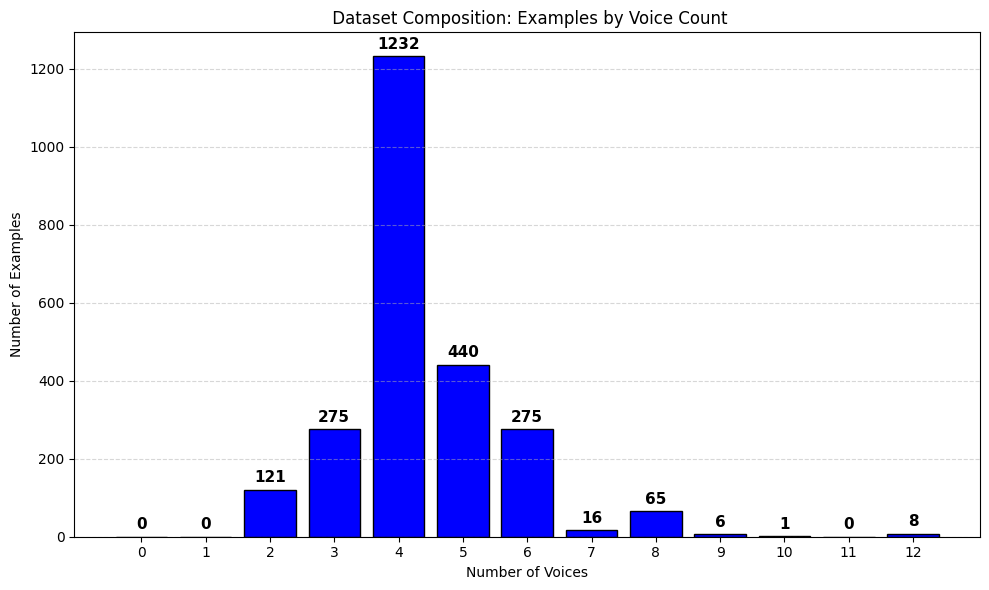

In [26]:
nb_programs = get_nb_programs(midi_paths)
nb_programs_bar(nb_programs)

### Train-Validation Split

In [27]:
train_paths, val_paths = train_test_split(midi_paths, random_state=SEED, test_size=0.05)
print(f"Test val split with {len(train_paths)} train examples and {len(val_paths)} val examples.")

Test val split with 2317 train examples and 122 val examples.


  0%|          | 0/2317 [00:00<?, ?it/s]

Found 0 examples with 0 voices.
Found 0 examples with 1 voices.
Found 115 examples with 2 voices.
Found 261 examples with 3 voices.
Found 1168 examples with 4 voices.
Found 418 examples with 5 voices.
Found 261 examples with 6 voices.
Found 15 examples with 7 voices.
Found 64 examples with 8 voices.
Found 6 examples with 9 voices.
Found 1 examples with 10 voices.
Found 0 examples with 11 voices.
Found 8 examples with 12 voices.


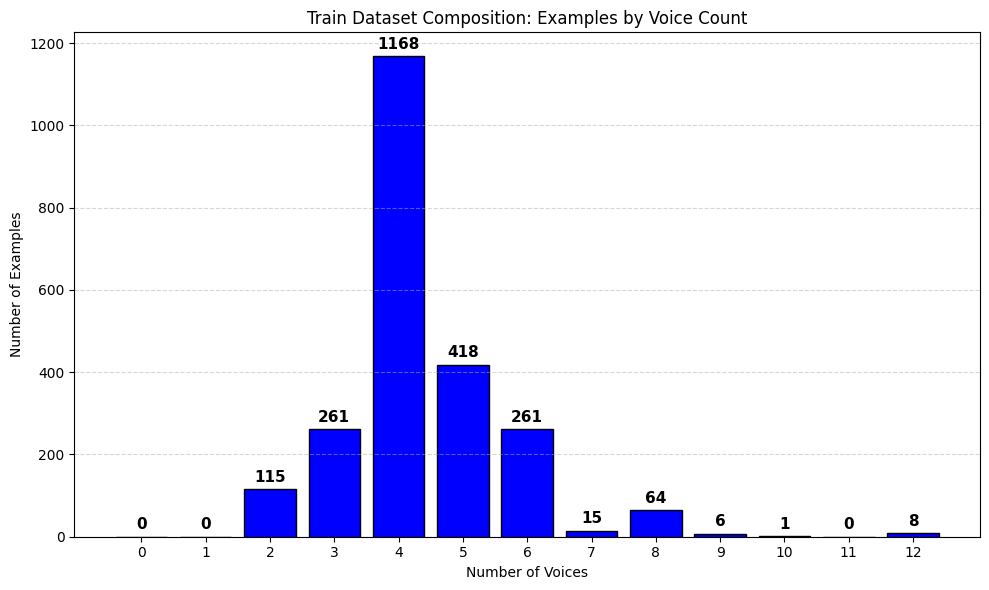

In [28]:
train_nb_programs = get_nb_programs(train_paths)
nb_programs_bar(train_nb_programs, "Train")

  0%|          | 0/122 [00:00<?, ?it/s]

Found 0 examples with 0 voices.
Found 0 examples with 1 voices.
Found 6 examples with 2 voices.
Found 14 examples with 3 voices.
Found 64 examples with 4 voices.
Found 22 examples with 5 voices.
Found 14 examples with 6 voices.
Found 1 examples with 7 voices.
Found 1 examples with 8 voices.
Found 0 examples with 9 voices.
Found 0 examples with 10 voices.
Found 0 examples with 11 voices.
Found 0 examples with 12 voices.


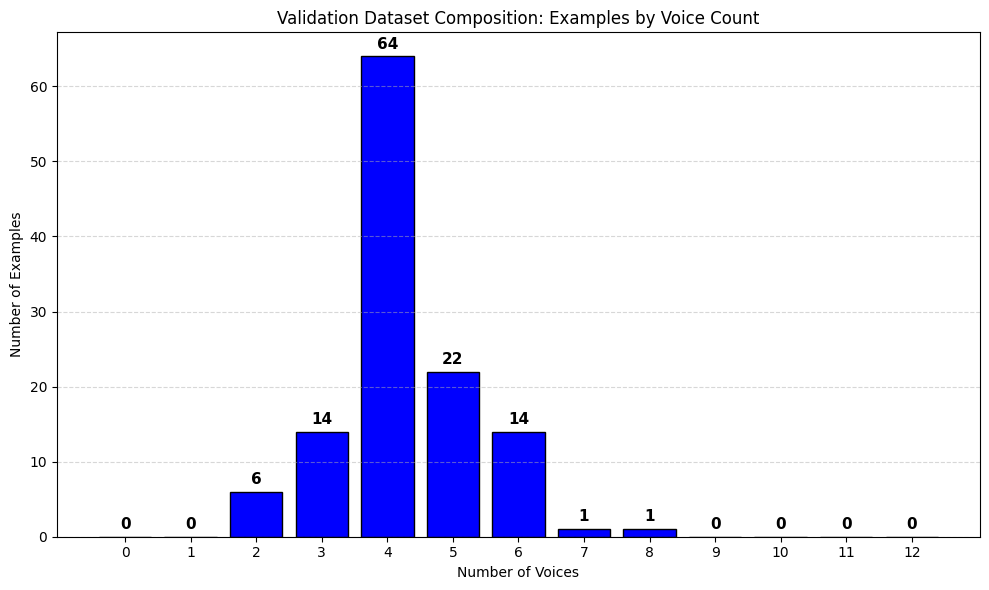

In [29]:
val_nb_programs = get_nb_programs(val_paths)
nb_programs_bar(val_nb_programs, "Validation")

### Data Augmentation

In [32]:
# data augmentation
process_directory_parallel(
    [Path(p) for p in train_paths],
    Path(TRAIN_DIR),
    min_semitones=-5,
    max_semitones=6,
)

Transposition range: -5 to 6 (12 versions each)
Output directory: /content/drive/MyDrive/RenaissanceREMI/augmented_train_data
Using 2 workers



  0%|          | 0/2317 [00:00<?, ?it/s]


Total files created: 27804


27804

In [33]:
process_directory_parallel(
    [Path(p) for p in val_paths],
    Path(VAL_DIR),
    min_semitones=-5,
    max_semitones=6,
)

Transposition range: -5 to 6 (12 versions each)
Output directory: /content/drive/MyDrive/RenaissanceREMI/augmented_val_data
Using 2 workers



  0%|          | 0/122 [00:00<?, ?it/s]


Total files created: 1464


1464

In [34]:
train_len = len([p for p in Path(TRAIN_DIR).iterdir() if p.is_file()])
val_len = len([p for p in Path(VAL_DIR).iterdir() if p.is_file()])
print(f"train_len={train_len}, val_len={val_len}")
assert(train_len + val_len == len(midi_paths) * 12)

train_len=27804, val_len=1464


### Hugging Face Dataset

In [35]:
def get_file_paths(directory_path):
    p = Path(directory_path)
    file_paths = [str(item.resolve()) for item in p.iterdir() if item.is_file()]
    return file_paths


augmented_train_paths = get_file_paths(TRAIN_DIR)
augmented_val_paths = get_file_paths(VAL_DIR)
print(len(augmented_train_paths), len(augmented_val_paths))
assert len(augmented_train_paths) == len(train_paths) * 12
assert len(augmented_val_paths) == len(val_paths) * 12

27804 1464


In [36]:
if not Path(AUGMENTED_TRAIN_DATASET_PATH).exists() or \
   not Path(AUGMENTED_VAL_DATASET_PATH).exists():

  train_dataset = build_polyphony_dataset(augmented_train_paths, TOKENIZER_PATH, AUGMENTED_TRAIN_DATASET_PATH)
  val_dataset = build_polyphony_dataset(augmented_val_paths, TOKENIZER_PATH, AUGMENTED_VAL_DATASET_PATH)


  # for next time
  train_dataset.save_to_disk(AUGMENTED_TRAIN_DATASET_PATH)
  val_dataset.save_to_disk(AUGMENTED_VAL_DATASET_PATH)
  print("Augmented datasets saved.")

else:

  train_dataset = load_from_disk(AUGMENTED_TRAIN_DATASET_PATH)
  val_dataset = load_from_disk(AUGMENTED_VAL_DATASET_PATH)

### Verify Programs in Tokenized Augmented Data

In [37]:
def count_programs_in_sequence(token_ids, tokenizer):
    token_strings = tokenizer.tokenizer._ids_to_tokens(token_ids)
    programs = set()
    for t in token_strings:
        if t.startswith("Program_"):
            programs.add(int(t.split("_")[1]))
    return programs

# Check all sequences in train dataset
program_counts = []
single_program_samples = []

for i, sample in enumerate(tqdm(train_dataset, desc="Checking programs")):
    programs = count_programs_in_sequence(sample['token_ids'], tokenizer)
    program_counts.append(len(programs))
    if len(programs) <= 1:
        single_program_samples.append({
            'index': i,
            'filename': sample['filename'],
            'programs': programs,
            'num_tokens': len(sample['token_ids'])
        })

# Summary
print(f"\nProgram count distribution:")
for count, freq in sorted(Counter(program_counts).items()):
    print(f"  {count} programs: {freq} sequences ({freq/len(program_counts)*100:.1f}%)")

print(f"\nSequences with 0 or 1 program: {len(single_program_samples)}")
if single_program_samples:
    print("\nFirst 10 single-program samples:")
    for s in single_program_samples[:10]:
        print(f"  [{s['index']}] {s['filename']}: programs={s['programs']}, tokens={s['num_tokens']}")

Checking programs:   0%|          | 0/27804 [00:00<?, ?it/s]


Program count distribution:
  2 programs: 1392 sequences (5.0%)
  3 programs: 3144 sequences (11.3%)
  4 programs: 14088 sequences (50.7%)
  5 programs: 4980 sequences (17.9%)
  6 programs: 3108 sequences (11.2%)
  7 programs: 192 sequences (0.7%)
  8 programs: 744 sequences (2.7%)
  9 programs: 60 sequences (0.2%)
  10 programs: 12 sequences (0.0%)
  12 programs: 84 sequences (0.3%)

Sequences with 0 or 1 program: 0


### View distribution of token sequence lengths in train

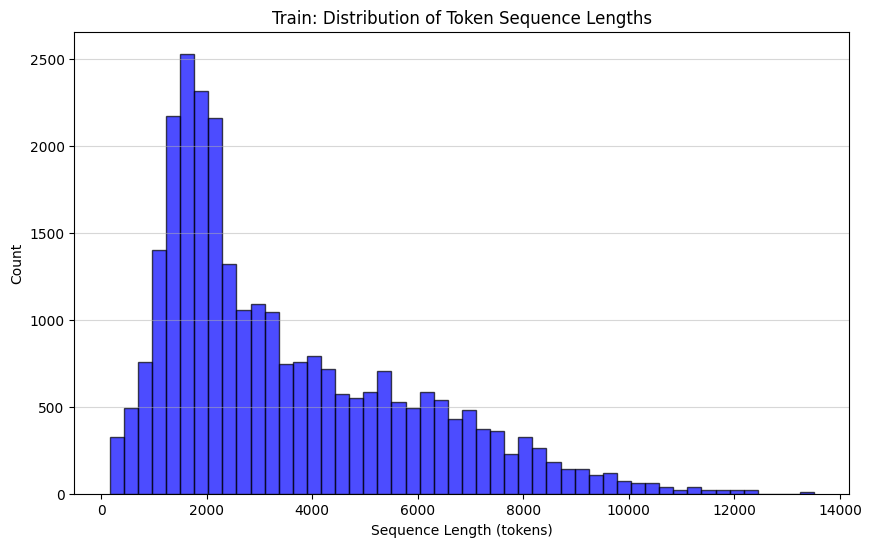

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Switch to NumPy format (zero-copy)
train_dataset.set_format(type="numpy", columns=["length"])

# Extract the column (this is now a numpy array, not a list)
lengths = train_dataset["length"]

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Train: Distribution of Token Sequence Lengths")
plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.5)
plt.show()

# Reset format to use the dataset normally afterwards
train_dataset.reset_format()

### And in Validation - Similar Distribution

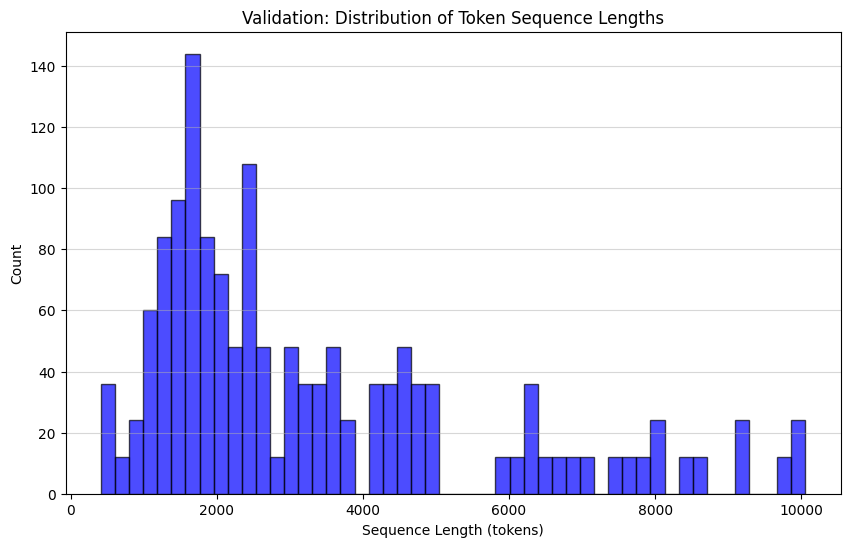

In [39]:
val_dataset.set_format(type="numpy", columns=["length"])

lengths = val_dataset["length"]

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Validation: Distribution of Token Sequence Lengths")
plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.5)
plt.show()

# Reset format to use the dataset normally afterwards
val_dataset.reset_format()

### Finished

The OUTPUT_BASE_DIR should now contain all the data and directories needed to train a model (cf. RenaissanceREMI_Train.ipynb)